In [1]:
import os
import flexynesis
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import lightning as pl
import glob

Seed set to 42


## Benchmarking of Different Deep Learning Architectures and Different Combinations of Omic Data Modalities with Human Cancer Cell Lines from the CCLE and GDSC Databases. 

Dataset downloading: 
```bash
        curl -L -o ccle_vs_gdsc.tgz \
        https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/ccle_vs_gdsc.tgz

        tar -xzvf ccle_vs_gdsc.tgz

### Database exploration

In [2]:
# Investigating the dimension of the data

# train data
train_dir = "ccle_vs_gdsc/train/*"

for file_path in glob.glob(train_dir):
    df = pd.read_csv(file_path)
    print(file_path, df.shape)

# the ocmics data has different shapes (no common dimensions in some of them)

ccle_vs_gdsc/train/clin.csv (1050, 25)
ccle_vs_gdsc/train/mutation.csv (1667, 1050)
ccle_vs_gdsc/train/cnv.csv (22907, 943)
ccle_vs_gdsc/train/rna.csv (18196, 1034)


In [3]:
# test data
test_dir = "ccle_vs_gdsc/test/*"

for file_path in glob.glob(test_dir):
    df = pd.read_csv(file_path)
    print(file_path, df.shape)

ccle_vs_gdsc/test/clin.csv (1074, 191)
ccle_vs_gdsc/test/mutation.csv (67, 707)
ccle_vs_gdsc/test/cnv.csv (22902, 968)
ccle_vs_gdsc/test/rna.csv (11647, 727)


In [4]:
clin_df = pd.read_csv("ccle_vs_gdsc/train/clin.csv")
print(list(clin_df.columns)) # the drug response of interest "Erlotinib" 
clin_df.head() 

['tissueid', 'Crizotinib', 'Dovitinib', 'Erlotinib', 'Irinotecan', 'L-685458', 'Lapatinib', 'LBW242', 'Nilotinib', 'Nutlin-3', 'Nvp-aew541', 'Nvp-tae 684', 'Paclitaxel', 'Palbociclib', 'Panobinostat', 'PD-0325901', 'Pha-665752', 'PLX4720', 'Raf265(chir-265)', 'Saracatinib', 'Selumetinib', 'Sorafenib', 'Tanespimycin', 'Topotecan', 'Vandetanib']


,tissueid,Crizotinib,Dovitinib,Erlotinib,Irinotecan,L-685458,Lapatinib,LBW242,Nilotinib,Nutlin-3,...,PD-0325901,Pha-665752,PLX4720,Raf265(chir-265),Saracatinib,Selumetinib,Sorafenib,Tanespimycin,Topotecan,Vandetanib
1321N1,CNS/Brain,0.023456,0.192017,0.058835,NaN,0.049021,0.042293,0.000000,NaN,0.103925,...,0.115318,0.006909,0.061913,0.179112,0.239268,0.110704,0.013212,NaN,0.463345,0.111488
143B,Bone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,Prostate,0.073845,0.074783,0.005032,0.506325,0.002515,0.038055,0.045213,3.915114e-14,0.014796,...,0.393936,0.051144,0.098720,0.056671,0.041118,0.372499,0.038337,0.345198,0.467487,0.034634
23132/87,Esophagus/Stomach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253J,Bladder/Urinary Tract,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plan for Combinations 

In [5]:
architectures = ["DP", "VAE", "GNN"] # Dense layers, Supervised variational auto-encoder, graph convolutional nets
omics_inputs = ["mutation_rna", "mutation_cnv", "rna_cnv"]
fusion_types = ["early", "middle"]
combination_list = list()
combinations_prefix = list()

for arch in architectures:
    for input_type in omics_inputs:
        for fusion in fusion_types:
            if arch == "GNN" and fusion == "middle":
                continue
            combination_list.append((arch, input_type, fusion))
            combinations_prefix.append(f"{arch}_{input_type}_{fusion}")
            

print(f"number of combinations: {len(combination_list)}", "\n")
print(combinations_prefix)

number of combinations: 15 

['DP_mutation_rna_early', 'DP_mutation_rna_middle', 'DP_mutation_cnv_early', 'DP_mutation_cnv_middle', 'DP_rna_cnv_early', 'DP_rna_cnv_middle', 'VAE_mutation_rna_early', 'VAE_mutation_rna_middle', 'VAE_mutation_cnv_early', 'VAE_mutation_cnv_middle', 'VAE_rna_cnv_early', 'VAE_rna_cnv_middle', 'GNN_mutation_rna_early', 'GNN_mutation_cnv_early', 'GNN_rna_cnv_early']


Besides, we can use a feature restriction to rule out some features and thus accelerating the training process. In addition, we can use hyperparameter optimization search to speed up the process further. 

The template for the command-line used (gets adjusted according to the the combination) 

```bash
flexynesis  --data_path ../ccle_vs_gdsc \
            --model_class GNN \
            --data_types rna,cnv \
            --target_variables Erlotinib \
            --hpo_iter 20 \
            --fusion_type early \
            --features_top_percentile 10 \
            --variance_threshold 0.8 \
            --prefix GNN_rna_cnv_early \
            --gnn_conv_type GC
   

In [6]:
combinations_considered = ['DP_mutation_rna_early', "DP_mutation_rna_middle", "DP_mutation_cnv_early", 
                           "VAE_mutation_rna_early", "VAE_mutation_rna_middle", "DP_rna_cnv_middle", "GNN_mutation_rna_early", "GNN_rna_cnv_early"]

### Finding out the BEST Combination

In [7]:
main_dir = "Benchmarking Results"

for root, _ , files in os.walk(main_dir):
    if files: 
        print(f"Files in {root}:")
        for file in files:
            print(f"  - {file}")
        print() 

Files in Benchmarking Results/DP_mutation_rna_early:
  - DP_mutation_rna_early.stats.csv
  - DP_mutation_rna_early.feature_logs.mutation.csv
  - DP_mutation_rna_early.predicted_labels.csv
  - DP_mutation_rna_early.feature_importance.IntegratedGradients.csv
  - DP_mutation_rna_early.embeddings_test.csv
  - DP_mutation_rna_early.embeddings_train.csv
  - DP_mutation_rna_early.feature_logs.rna.csv

Files in Benchmarking Results/DP_mutation_rna_middle:
  - DP_mutation_rna_middle.stats.csv
  - DP_mutation_rna_middle.feature_logs.mutation.csv
  - DP_mutation_rna_middle.predicted_labels.csv
  - DP_mutation_rna_middle.feature_importance.IntegratedGradients.csv
  - DP_mutation_rna_middle.feature_logs.rna.csv
  - DP_mutation_rna_middle.embeddings_train.csv
  - DP_mutation_rna_middle.embeddings_test.csv

Files in Benchmarking Results/DP_mutation_cnv_early:
  - DP_mutation_cnv_early.stats.csv
  - DP_mutation_cnv_early.feature_logs.mutation.csv
  - DP_mutation_cnv_early.predicted_labels.csv
  - DP_m

In [8]:
# Looking at the stats for one combination
sample_stats = "Benchmarking Results/GNN_rna_cnv_early/GNN_rna_cnv_early.stats.csv"
sample_stats = "Benchmarking Results/DP_mutation_rna_early/DP_mutation_rna_early.stats.csv"


stats_df = pd.read_csv(sample_stats)
print("pearson_corr: ", stats_df.loc[2, 'value'])

pearson_corr:  0.4329288898025534


In [9]:
main_dir = "Benchmarking Results/*"
stats_dict = dict()
for sub_dir in glob.glob(main_dir):
    sub_dir_name = sub_dir.split("/")[-1]
    stats_file_name = f"{sub_dir_name}.stats.csv"
    stats_file = os.path.join(sub_dir, stats_file_name)
    stats_df = pd.read_csv(stats_file)
    stats_dict[sub_dir_name] = round(stats_df.loc[2, "value"], 4)

stats_dict

{'DP_mutation_rna_early': 0.4329,
 'DP_mutation_rna_middle': 0.4136,
 'DP_mutation_cnv_early': 0.087,
 'VAE_mutation_rna_early': 0.4092,
 'VAE_mutation_rna_middle': 0.4151,
 'DP_rna_cnv_middle': 0.3862,
 'GNN_mutation_rna_early': 0.3539,
 'GNN_rna_cnv_early': 0.3479}

/gnu/store/88qdfdp9h0003w4wp1rv46khc3dpp8j6-profile/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/gnu/store/88qdfdp9h0003w4wp1rv46khc3dpp8j6-profile/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/gnu/store/88qdfdp9h0003w4wp1rv46khc3dpp8j6-profile/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/gnu/store/88qdfdp9h0003w4wp1rv46khc3dpp8j6-profile/lib/python3.10/site-packages/seaborn/_base.py:94

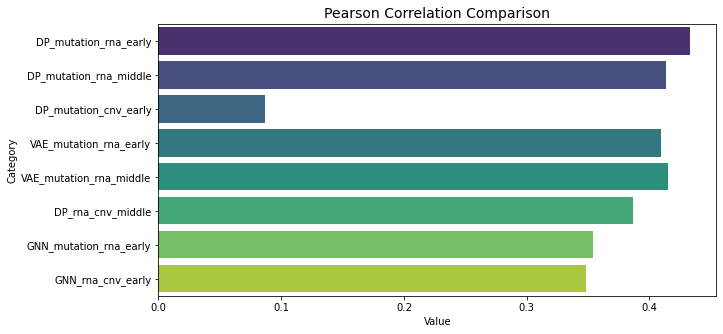

In [10]:
stats_df = pd.DataFrame(list(stats_dict.items()), columns=['Category', 'Value'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Value', y='Category', data=stats_df, hue='Category', dodge=False, legend=False, palette='viridis')
plt.title('Pearson Correlation Comparison', fontsize=14)
plt.show()

From the above horizontal bar chart, we can deduce that the best combination is **(DirectPred + (mutation & rna) + early fusion)**

### Explore the Train/Test Embeddings from the Best Combination

In [21]:
best_combination = "Benchmarking Results/DP_mutation_rna_early"
train_embeddings_path = os.path.join(best_combination, "DP_mutation_rna_early.embeddings_train.csv")
test_embeddings_path = os.path.join(best_combination, "DP_mutation_rna_early.embeddings_test.csv")

In [74]:
train_embeddings = pd.read_csv(train_embeddings_path)
				

test_embeddings = pd.read_csv(test_embeddings_path)

train_embeddings.shape, test_embeddings.shape

((1034, 19), (609, 19))

In [75]:
train_embeddings.head()

,Unnamed: 0,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17
0,MM1.S,-15.349139,-3.258429,-0.068481,7.333355,-9.585272,-5.322856,13.897924,-2.592313,7.884480,-7.493834,-18.420391,7.014343,-13.427064,12.202229,-0.169701,2.726859,11.082131,5.304385
1,NCI-H1048,0.491836,2.350447,-1.308296,-0.598745,1.537960,0.307605,-0.897100,1.649819,1.426379,-0.051489,0.676659,0.103922,-0.235644,1.257764,-0.331808,2.105984,-0.919037,0.256722
2,NCI-H2052,7.356605,-3.888465,0.081874,-4.744175,-3.605103,3.893994,-3.614181,-4.748874,-9.190386,2.536394,6.465742,0.766941,6.951962,-4.969381,-4.582633,-5.616127,-3.941779,-6.369562
3,RS-5,14.990322,-7.795188,0.495248,-6.399478,-6.840939,7.411182,-6.950261,-9.994192,-16.550670,4.030861,9.901467,-0.784108,11.168738,-9.725503,-10.163548,-10.500711,-6.945054,-10.428004
4,KYSE-270,1.804632,1.762210,-1.160672,-6.425827,2.014534,-1.210420,-2.425218,3.786789,-2.840501,0.635219,5.974826,1.796611,4.215107,-0.594575,0.717093,-0.970041,-3.475329,-3.459842


In [79]:
num_cols = [col for col in train_embeddings.columns if col.startswith('E')]
train_embeddings = train_embeddings[num_cols]
train_embeddings.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17
0,-15.349139,-3.258429,-0.068481,7.333355,-9.585272,-5.322856,13.897924,-2.592313,7.884480,-7.493834,-18.420391,7.014343,-13.427064,12.202229,-0.169701,2.726859,11.082131,5.304385
1,0.491836,2.350447,-1.308296,-0.598745,1.537960,0.307605,-0.897100,1.649819,1.426379,-0.051489,0.676659,0.103922,-0.235644,1.257764,-0.331808,2.105984,-0.919037,0.256722
2,7.356605,-3.888465,0.081874,-4.744175,-3.605103,3.893994,-3.614181,-4.748874,-9.190386,2.536394,6.465742,0.766941,6.951962,-4.969381,-4.582633,-5.616127,-3.941779,-6.369562
3,14.990322,-7.795188,0.495248,-6.399478,-6.840939,7.411182,-6.950261,-9.994192,-16.550670,4.030861,9.901467,-0.784108,11.168738,-9.725503,-10.163548,-10.500711,-6.945054,-10.428004
4,1.804632,1.762210,-1.160672,-6.425827,2.014534,-1.210420,-2.425218,3.786789,-2.840501,0.635219,5.974826,1.796611,4.215107,-0.594575,0.717093,-0.970041,-3.475329,-3.459842


In [80]:
num_cols = [col for col in test_embeddings.columns if col.startswith('E')]
test_embeddings = test_embeddings[num_cols]
test_embeddings.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17
0,3.800640,-2.228356,-0.328616,-1.668035,-2.426082,2.366106,-1.598358,-3.450395,-4.477411,1.087807,2.511777,0.694414,2.872893,-2.572881,-2.484574,-3.015020,-1.671741,-3.469859
1,-1.965425,4.556587,-2.897637,-0.145928,1.832738,-0.406949,0.699332,3.091784,3.837183,-1.594470,-1.635708,0.901963,-3.146460,4.490825,-0.922885,4.689667,-0.468691,0.916003
2,4.785348,-2.635619,-0.792731,-3.565520,-2.501747,2.643855,-2.161354,-3.624273,-6.827052,1.417372,4.288302,1.154311,4.181413,-3.489071,-3.481883,-4.509522,-2.986620,-5.522976
3,-0.395990,2.462965,-1.687171,-4.458892,1.618885,-1.256759,-0.970276,2.973071,-0.663056,-0.190396,3.008270,2.157007,1.469248,0.762468,0.867175,0.208598,-2.534399,-2.731336
4,-5.514925,2.053672,-2.245745,0.678501,-1.288632,-1.450843,3.903121,1.607559,4.012192,-2.848527,-5.145458,1.813999,-5.701118,5.224642,-0.251825,2.736031,1.762969,0.776312


In [66]:
predicted_labels_path = os.path.join(best_combination, "DP_mutation_rna_early.predicted_labels.csv")
predicted_labels = pd.read_csv(predicted_labels_path)
predicted_labels.head()

,sample_id,variable,class_label,probability,known_label,predicted_label,split
0,MM1.S,Erlotinib,NaN,NaN,NaN,0.025005,train
1,NCI-H1048,Erlotinib,NaN,NaN,0.031623,0.035577,train
2,NCI-H2052,Erlotinib,NaN,NaN,0.083207,0.057813,train
3,RS-5,Erlotinib,NaN,NaN,NaN,0.034414,train
4,KYSE-270,Erlotinib,NaN,NaN,NaN,0.188523,train


In [81]:
train_df = predicted_labels[predicted_labels['split'] == 'train']
test_df = predicted_labels[predicted_labels['split'] == 'test']

train_labels = list(train_df.loc[:,"known_label"])
test_labels = list(test_df.loc[:,"known_label"])

In [88]:
print(len(train_labels), "---------" ,len(test_labels))
print(len(train_embeddings), "---------" ,len(test_embeddings))
# they have the same number of samples

1034 --------- 609
1034 --------- 609


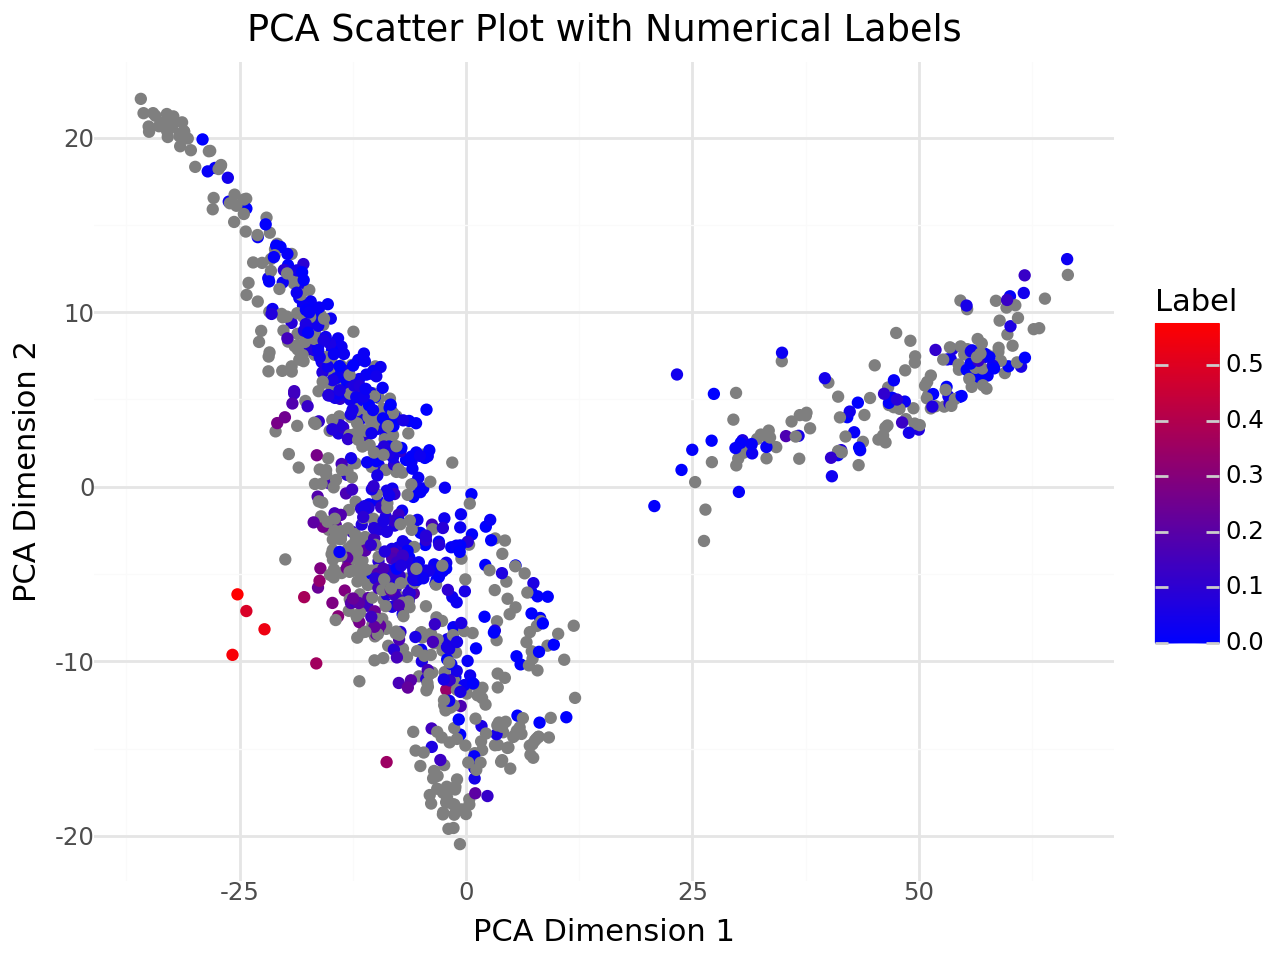

In [89]:
# train data embeddings (labeled + NAN Values)
flexynesis.plot_dim_reduced(train_embeddings, train_labels ,color_type = 'numerical', method='pca')

The samples that have no label are colored in gray.

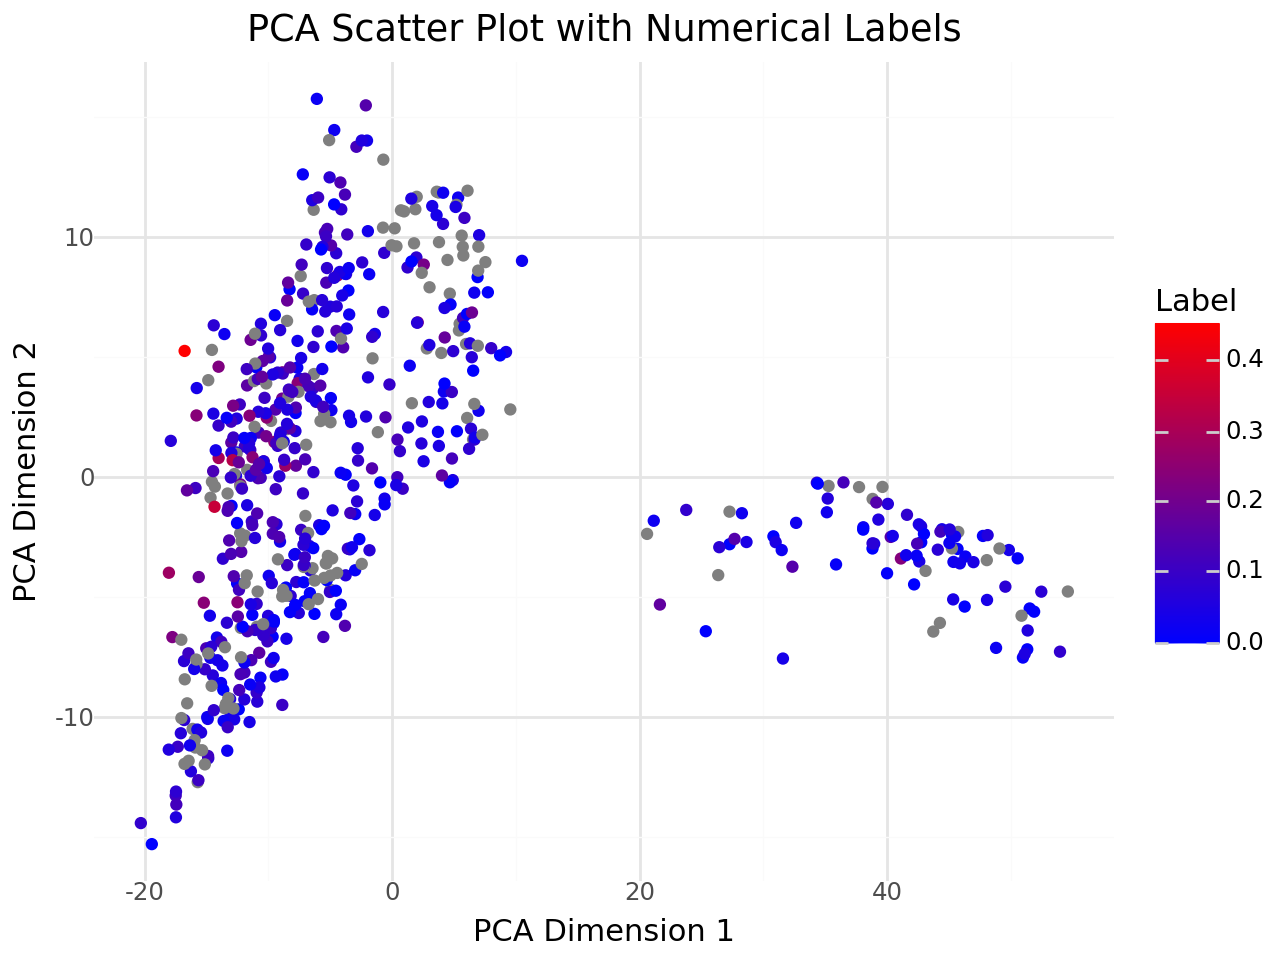

In [90]:
# test data embeddings (labeled + NAN Values)
flexynesis.plot_dim_reduced(test_embeddings, test_labels ,color_type = 'numerical', method='pca')

### Feature Importance Scores from the Best Combination

In [105]:
importance_score_path = os.path.join(best_combination, "DP_mutation_rna_early.feature_importance.IntegratedGradients.csv")
importance_score = pd.read_csv(importance_score_path)
importance_score.head(10)

,target_variable,target_class,target_class_label,layer,name,importance,explainer
0,Erlotinib,0,NaN,all,TNFRSF17,0.000044,IntegratedGradients
1,Erlotinib,0,NaN,all,SOX10,0.000149,IntegratedGradients
2,Erlotinib,0,NaN,all,IKZF1,0.000220,IntegratedGradients
3,Erlotinib,0,NaN,all,BTK,0.000179,IntegratedGradients
4,Erlotinib,0,NaN,all,VPREB3,0.000140,IntegratedGradients
5,Erlotinib,0,NaN,all,YAP1,0.000069,IntegratedGradients
6,Erlotinib,0,NaN,all,MLANA,0.000142,IntegratedGradients
7,Erlotinib,0,NaN,all,MZB1,0.000192,IntegratedGradients
8,Erlotinib,0,NaN,all,KLF1,0.000088,IntegratedGradients
9,Erlotinib,0,NaN,all,GRHL2,0.000733,IntegratedGradients


In [104]:
df_sorted = importance_score.sort_values(by='importance', ascending=False).reset_index(drop=True)
df_sorted.head(10)

,target_variable,target_class,target_class_label,layer,name,importance,explainer
0,Erlotinib,0,NaN,all,KRAS,0.002271,IntegratedGradients
1,Erlotinib,0,NaN,all,LPAR1,0.001676,IntegratedGradients
2,Erlotinib,0,NaN,all,FA2H,0.001583,IntegratedGradients
3,Erlotinib,0,NaN,all,HKDC1,0.001566,IntegratedGradients
4,Erlotinib,0,NaN,all,EFHD1,0.001535,IntegratedGradients
5,Erlotinib,0,NaN,all,ABLIM3,0.001526,IntegratedGradients
6,Erlotinib,0,NaN,all,XDH,0.001519,IntegratedGradients
7,Erlotinib,0,NaN,all,CNN1,0.001415,IntegratedGradients
8,Erlotinib,0,NaN,all,WNT7A,0.001398,IntegratedGradients
9,Erlotinib,0,NaN,all,EGFR,0.001383,IntegratedGradients


#### Literature Search for Associations with Erlotinib

1. **KRAS**: Frequently mutated in various cancers, particularly non-small cell lung cancer (NSCLC), and is known to influence response to targeted therapies, including Erlotinib.

2. **LPAR1**: Less commonly discussed in the context of Erlotinib, but may have roles in cancer progression and metastasis.

3. **FA2H**: Limited direct association with Erlotinib in literature; further research may be needed.

4. **HKDC1**: Not widely reported in relation to Erlotinib; more investigation required.

5. **EFHD1**: Limited information available regarding its role in Erlotinib response.

6. **ABLIM3**: Not commonly associated with Erlotinib; further studies may be necessary.

7. **XDH**: Some studies suggest a role in cancer metabolism, but direct links to Erlotinib are sparse.

8. **CNN1**: Limited literature connecting CNN1 to Erlotinib.

9. **WNT7A**: Some studies suggest involvement in cancer pathways, but direct association with Erlotinib is not well established.

10. **EGFR**: A well-known target of Erlotinib, as it is an EGFR inhibitor used primarily in NSCLC treatment.

#### Conclusion

Among the top markers, **EGFR** and **KRAS** have established associations with Erlotinib. The other markers may require further investigation to determine their relevance in the context of Erlotinib treatment.